In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
from scipy import stats
import pickle

In [2]:
# Carregando o data frame
df = pd.read_excel('../data/preprocessed.xlsx', index_col=0)

In [3]:
df.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,QUALIDADE
0,320.15,0.88,0,10.144919,2
1,320.14,1.55,0,11.547027,2
2,284.85,2.97,0,11.112109,2
3,263.92,2.36,2,9.900123,0
4,276.22,2.98,2,10.079822,2


In [72]:
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())

def calc_metrics(ytest, ypred):
    # Calculate the absolute errors
    errors = abs(ypred - ytest)
    #Avaliando modelo com dados de teste
    r2 = r2_score(ytest,ypred)
    rss = calc_rss(ytest,ypred)
    meanabs = mean_absolute_error(ytest,ypred)

    # mean absolute percentage error (MAPE)
    mape = 100 * (errors / ytest)
    #accuracy
    accuracy = 100 - np.mean(mape)

    print('Accuracy:', round(accuracy, 2), '%.')
    print("R2 score: {:.3f}".format(r2))
    print("RSS score: {:.3f}".format(rss))
    print("Mean absolute error: {:.3f}".format(meanabs))
    
def plot_resid(ytest, ypred, ytrain, ypred_train):
    plt.scatter(ypred_train, ypred_train - ytrain,
                color = "green", s = 10, label = 'Train data')
    plt.scatter(ypred, ypred - ytest,
                color = "blue", s = 10, label = 'Test data')

    ## plotting line for zero residual error
    plt.hlines(y = 0, xmin = np.min(ypred_train), xmax = np.max(ypred_train), linewidth = 2)
    plt.legend(loc = 'upper right')
    plt.title("Residual errors")
    plt.show()

In [73]:
# Normalizacao
min_max_scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns)

In [74]:
# Criando objetos de treino e teste
X = df.iloc[:, 0:3].values
y = df['PESO_BOMBOM'].values

X_norm = df_norm.iloc[:, 0:3].values
y_norm = df_norm['PESO_BOMBOM'].values

In [75]:
# Criando dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Imprimindo os resultados
print("{0:0.2f}% nos dados de treino".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(X_test)/len(df.index)) * 100))

69.82% nos dados de treino
30.18% nos dados de teste


#### Linear model

In [76]:
# create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
reg.fit(X_train, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [ 0.01062642  0.77277251 -0.55147231]
Variance score: 0.5253484000578852


In [77]:
#Avaliando modelo com dados de teste
calc_metrics(y_test,reg.predict(X_test))

Accuracy: 92.88 %.
R2 score: 0.525
RSS score: 124.647
Mean absolute error: 0.709


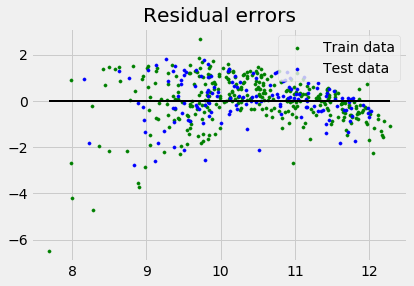

In [78]:
# Residual error
plot_resid(y_test, reg.predict(X_test),y_train, reg.predict(X_train))

#### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [83]:
calc_metrics(y_test,rf.predict(X_test))

Accuracy: 93.98 %.
R2 score: 0.653
RSS score: 91.123
Mean absolute error: 0.593


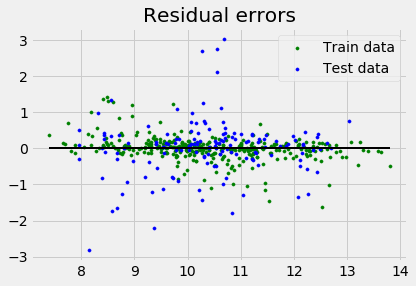

In [81]:
# Residual error
plot_resid(y_test, rf.predict(X_test),y_train, rf.predict(X_train))

In [93]:
list(df.iloc[:, 0:3].columns)

['QTD_CHOC', 'VAR_1', 'VAR_2']

In [110]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(x, round(importance, 2)) for x, importance in zip(list(df.iloc[:, 0:3].columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: VAR_2                Importance: 0.44
Variable: VAR_1                Importance: 0.31
Variable: QTD_CHOC             Importance: 0.25


In [115]:
with open('../model/rfmodel_pkl', 'wb') as files:
    pickle.dump(rf, files)

### Preenchendo a planilha

In [148]:
# Carregando o data frame
df_pred = pd.read_excel('../data/analise-preditiva.xlsx')
df_pred_copy = df_pred.copy()
df_pred_copy.loc[:,'VAR_2'] = df_pred.loc[:,'VAR_2'].astype('category').cat.codes
df_pred_copy.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
0,286.63,2.72,0,NaN
1,257.27,1.97,1,NaN
2,353.16,2.64,0,NaN
3,317.78,2.76,0,NaN
4,248.10,2.63,2,NaN


In [149]:
# Carregando modelo
with open('../model/rfmodel_pkl' , 'rb') as f:
    rfmodel = pickle.load(f)

X_pred = df_pred_copy.iloc[:, 0:3].values
rfmodel.predict([X_pred[0]])

array([11.4878921])

In [167]:
rfmodel.predict([[266.830617,2.94,1]])

array([10.51754138])

In [150]:
# Populando a coluna PESO_BOMBOM
df_pred.loc[:,'PESO_BOMBOM'] = rfmodel.predict(X_pred)

In [151]:
df_pred.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
0,286.63,2.72,A,11.487892
1,257.27,1.97,B,8.478249
2,353.16,2.64,A,12.768053
3,317.78,2.76,A,11.894899
4,248.10,2.63,C,10.081246


In [153]:
df_pred.to_excel("../data/analise-preditiva-resultado.xlsx", index=False)  